In [23]:
import numpy as np
import pandas as pd
import re, os
from plot_funcs import *

In [3]:
def get_inf_from_csv(filepath):
    df = pd.read_csv(filepath)
    return float(df["expected spread"].iloc[-1])

def get_inf_from_csv_one_method(dataset:str, method:str):
    res = []
    for i, rand_seed in enumerate(range(2021, 2026)):
        res_for_diff_seeds = []
        for k_edge in [5, 10, 20, 30, 40, 50]:
            folder_path = f"./data/{dataset}/params/{k_edge}_0_0.500000_0.001000_{rand_seed}_WC/"
            csv_filename = os.path.join(folder_path, f"k_inf_spread_{method}.csv")
            res_for_diff_seeds.append(get_inf_from_csv(csv_filename))
        res.append(res_for_diff_seeds)
    res = np.mean(np.array(res), axis=0)
    return res

In [22]:

# plot_lines([get_inf_from_csv_one_method("Epinions", "AIS"), get_inf_from_csv_one_method("Epinions", "AISPAC")],
#            line_labels=["AIS", "AISPAC"],
#            x_axis=[5, 10, 20, 30, 40, 50],
#            ms=10,
#            x_label=r"$k$",
#            y_label="inf. spread",
#            fig_size=[4, 3],
#            save_path="./figs/inf_k_epin.pdf")
# plot_lines([get_inf_from_csv_one_method("DBLP", "AIS"), get_inf_from_csv_one_method("DBLP", "AISPAC")],
#            line_labels=["AIS", "AISPAC"],
#            x_axis=[5, 10, 20, 30, 40, 50],
#            ms=10,
#            x_label=r"$k$",
#            y_label="inf. spread",
#            fig_size=[4, 3],
#            save_path="./figs/inf_k_dblp.pdf")

FileNotFoundError: [Errno 2] No such file or directory: './data/Epinions/params/5_0_0.500000_0.001000_2021_WC/k_inf_spread_AIS.csv'

In [17]:
test = pd.read_csv(os.path.join(f"./data/nethept/params/50_10000_0.500000_0.001000_2023_RANDseed_WC/", "k_inf_spread_MCGreedy_1000.csv"))["expected spread"]
test.iloc[-1]

# Read data from files

In [66]:
BASELINE_NAMES = ["RAND", "OUTDEG", "PROB", "SINF", "UINF", "AIS-U" , "IMA"]
NUM_RR = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400]
RAND_SEEDS = [2021, 2022, 2023, 2024, 2025, 2026]
K_LIST = [5, 10, 20, 30, 40, 50]
EPS_LIST = ["0.1", "0.2", "0.3", "0.4", "0.5"]
BETA_LIST = [1, 2, 4, 8, 16, 32, 64]
rand_seeds_nethept = [42, 2020, 2022, 2023, 2024]

def get_res_from_file(file_path, mode="result")->float:
    with open(file_path, 'r') as file:
        match = None
        for line in file:
            if mode == "result" and line.startswith('Result by'):
                match = re.search(r'\d+(\.\d+)?', line)
            elif mode == "origin" and line.startswith("Original Inf:"):
                match = re.search(r'\d+(\.\d+)?', line)
            
        if match:
            number = float(match.group())
            return number
        else:
            print("RESULT NOT FOUND", file_path)

def get_RRset_generation_time(file_path):
    with open(file_path, "r") as file:
        contents = file.read()

        # Use regular expressions to extract the RR set generation time
        pattern = r"->Time used \(sec\) for operation \[RR set generation\]: (\d+\.\d+|\d+)"
        match = re.search(pattern, contents)

        if match:
            rr_set_time = float(match.group(1))
            return rr_set_time
        else:
            print("RR set generation time not found")
            return -1.0

def get_process_time(file_path):
    with open(file_path, "r") as file:
        # Read the contents of the file
        contents = file.read()

        # Use regular expressions to find the line with the keyword "process"
        pattern = r".*process.*"
        match = re.search(pattern, contents, re.MULTILINE)

        if match:
            line = match.group(0)
            # Use regular expressions to extract the running time from the line
            time_pattern = r"\d+(\.\d+)?"
            time_match = re.search(time_pattern, line)
            if time_match:
                running_time = float(time_match.group(0))
                return running_time
            else:
                print("Running time not found in the line with the keyword 'process'")
        else:
            print("Line with the keyword 'process' not found")

def get_original_inf(dataset_name:str, rand_seeds):
    res_arr = []
    for rand_seed in rand_seeds:
        path = f"./data/{dataset_name}/params/5_0_0.500000_0.001000_{rand_seed}_WC/log_IMA.txt"
        res_arr.append(get_res_from_file(path, "origin"))
    return sum(res_arr) / len(res_arr)

def get_inf_beta_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], k_edges=50):
    res = {}
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for beta in BETA_LIST:
                try:
                    if beta == 1:
                        path = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC/log_{baseline}.txt"
                    else:
                        path = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC_beta_{beta}/log_{baseline}.txt"
                    # print(path)
                    inf_for_one_rand_seed.append(get_res_from_file(path, "result"))
                except:
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        
        x_mean = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
        res[baseline] = x_mean / np.max(x_mean)
        # res[baseline] = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
    return res

def get_time_beta_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], k_edges=50):
    res = {}
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for beta in BETA_LIST:
                try:
                    if beta == 1:
                        working_folder = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC/"
                    else:
                        working_folder = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC_beta_{beta}/"
                    
                    log_path = os.path.join(working_folder, "logs.txt")
                    log_baseline_path = os.path.join(working_folder, f"log_{baseline}.txt")
                    RR_set_gen_time = get_RRset_generation_time(log_path)
                    process_time = get_process_time(log_baseline_path)
                    time_for_one_rand_seed.append(RR_set_gen_time + process_time)
                except Exception as e:
                    print(e.args)
                    print(baseline, rand_seed, k_edges)
                    print(working_folder)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_inf_spread_of_one_dataset(dataset_name:str, rand_seeds):
    res = {}
    origin_inf = get_original_inf(dataset_name, rand_seeds)
    for baseline in BASELINE_NAMES:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = [origin_inf]
            for k_edges in K_LIST:
                try:
                    path = f"./data/{dataset_name}/params/{k_edges}_0_0.500000_0.001000_{rand_seed}_WC/log_{baseline}.txt"
                    # print(path)
                    inf_for_one_rand_seed.append(get_res_from_file(path, "result"))
                except:
                    print(baseline, rand_seed, k_edges)
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        res[baseline] = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
    return res

def get_eps_inf_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], k_edges=50):
    res = {}
    
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for eps in EPS_LIST:
                try:
                    path = f"./data/{dataset_name}/params/{k_edges}_0_{eps}00000_0.001000_{rand_seed}_WC/log_{baseline}.txt"
                    # print(path)
                    inf_for_one_rand_seed.append(get_res_from_file(path, "result"))
                except:
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        x_mean = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
        res[baseline] = x_mean / np.max(x_mean)
    return res

def get_eps_time_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"]):
    res = {}
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for eps in EPS_LIST:
                try:
                    working_folder = f"./data/{dataset_name}/params/50_0_{eps}00000_0.001000_{rand_seed}_WC/"
                    log_path = os.path.join(working_folder, "logs.txt")
                    log_baseline_path = os.path.join(working_folder, f"log_{baseline}.txt")
                    RR_set_gen_time = get_RRset_generation_time(log_path)
                    process_time = get_process_time(log_baseline_path)
                    time_for_one_rand_seed.append(RR_set_gen_time + process_time)
                except Exception as e:
                    print(e.args)
                    print(working_folder)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["SINF", "UINF", "AIS-U" , "IMA"], k_list=K_LIST, seed_mode="IM",
                               num_cand_edges=0):
    res = {}
    for baseline in baseline_names:
        time_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            time_for_one_rand_seed = []
            for k_edges in k_list:
                try:
                    working_folder = f"./data/{dataset_name}/params/{k_edges}_{num_cand_edges}_0.500000_0.001000_{rand_seed}_WC/"
                    if seed_mode == "RAND":
                        working_folder = f"./data/{dataset_name}/params/{k_edges}_{num_cand_edges}_0.500000_0.001000_{rand_seed}_RANDseed_WC/"
                        
                    log_path = os.path.join(working_folder, "logs.txt")
                    if baseline == "AISPAC":
                        log_path = os.path.join(working_folder, "logs_for_AISPAC.txt")
                    log_baseline_path = os.path.join(working_folder, f"log_{baseline}.txt")
                    RR_set_gen_time = get_RRset_generation_time(log_path)
                    process_time = get_process_time(log_baseline_path)
                    if baseline in ["SINF", "UINF", "AIS-U" , "IMA"]:
                        time_for_one_rand_seed.append(RR_set_gen_time + process_time)
                    else:
                        time_for_one_rand_seed.append(process_time)
                except Exception as e:
                    print(e.args)
                    print(working_folder)
            time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res[baseline] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_k_mcg(dataset_name:str, rand_seeds:list, k_list=K_LIST, seed_mode="RAND", num_cand_edges=10000):
    res = {}

    time_diff_rand_seed_list = []
    for rand_seed in rand_seeds:
        time_for_one_rand_seed = []
        try:
            working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_WC/"
            if seed_mode == "RAND":
                working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_RANDseed_WC/"
            log_path = os.path.join(working_folder, "MCGreedy_10000_time.txt")
            with open(log_path, 'r') as f:
                contents = f.read()
                for k_edges in k_list:
                    pattern = r"\[select_" + str(k_edges) + r"\]:\s+(\d+(\.\d+)?)"
                    match = re.search(pattern, contents)
                    time_for_one_rand_seed.append(float(match.group(1)))
        except Exception as e:
            print(e.args)
            print(working_folder)
        time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res["MCGreedy"] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_runtime_r_mcg(dataset_name:str, rand_seeds:list, r_list=[2000, 4000, 6000, 8000, 10000], seed_mode="RAND", num_cand_edges=10000):
    res = {}

    time_diff_rand_seed_list = []
    for rand_seed in rand_seeds:
        time_for_one_rand_seed = []
        try:
            working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_WC/"
            if seed_mode == "RAND":
                working_folder = f"./data/{dataset_name}/params/50_{num_cand_edges}_0.500000_0.001000_{rand_seed}_RANDseed_WC/"
            for r in r_list:
                log_path = os.path.join(working_folder, f"MCGreedy_{str(r)}_time.txt")
                with open(log_path, 'r') as f:
                    contents = f.read()
                    pattern = r"\[select_50\]:\s+(\d+(\.\d+)?)"
                    match = re.search(pattern, contents)
                    time_for_one_rand_seed.append(float(match.group(1)))
        except Exception as e:
            print(e.args)
            print(working_folder)
            print(r)
        time_diff_rand_seed_list.append(time_for_one_rand_seed)
        res["MCGreedy"] = np.mean(np.array(time_diff_rand_seed_list), axis=0)
    return res

def get_inf_k_for_one_method():
    return

def display_for_tex(method_inf_dict, method="IMA", k_list = [0, 5, 10, 20, 30, 40, 50]):
    for i in range(len(method_inf_dict[method])):
        print(f"({k_list[i]},{round(method_inf_dict[method][i], 4)})")

def display_for_tex_all(method_inf_dict, k_list = [0, 5, 10, 20, 30, 40, 50]):
    for method in method_inf_dict.keys():
        print(method + ":")
        display_for_tex(method_inf_dict, method, k_list)
        
def get_inf_numRRsets_of_one_dataset(dataset_name:str, rand_seeds, baseline_names=["IMA"], seed_mode="RAND"):
    res = {}
    for baseline in baseline_names:
        inf_diff_rand_seed_list = []
        for rand_seed in rand_seeds:
            inf_for_one_rand_seed = []
            for num_samples in NUM_RR:
                try:
                    if seed_mode != "IM":
                        path = f"./data/{dataset_name}/params/50_0_0.000000_0.001000_{rand_seed}_{seed_mode}seed_WC_numsamples_{num_samples}/k_inf_spread_{baseline}.csv"
                    else:
                        path = f"./data/{dataset_name}/params/50_0_0.000000_0.001000_{rand_seed}_WC_numsamples_{num_samples}/k_inf_spread_{baseline}.csv"
                    # print(path)
                    inf_for_one_rand_seed.append(get_inf_from_csv(path))
                except:
                    print(baseline, rand_seed)
                    print(path)
            inf_diff_rand_seed_list.append(inf_for_one_rand_seed)
        res[baseline] = np.mean(np.array(inf_diff_rand_seed_list), axis=0)
    return res

In [50]:
inf_RRsets_epin_dict = get_inf_numRRsets_of_one_dataset("Epinions", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"])
inf_RRsets_epin_list = np.array(list(inf_RRsets_epin_dict.values()))

inf_RRsets_DBLP_dict = get_inf_numRRsets_of_one_dataset("DBLP", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"])
inf_RRsets_DBLP_list = np.array(list(inf_RRsets_DBLP_dict.values()))

inf_RRsets_LJ_dict = get_inf_numRRsets_of_one_dataset("LJ", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"])
inf_RRsets_LJ_list = np.array(list(inf_RRsets_LJ_dict.values()))

inf_RRsets_orkut_dict = get_inf_numRRsets_of_one_dataset("orkut", RAND_SEEDS, ["AISPAC", "AugIM", "AIS"])
inf_RRsets_orkut_list = np.array(list(inf_RRsets_orkut_dict.values()))

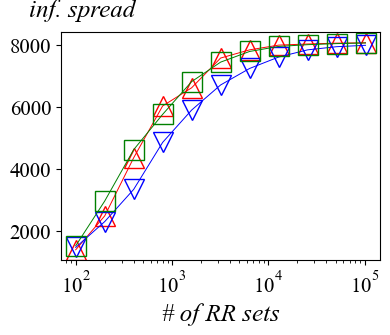

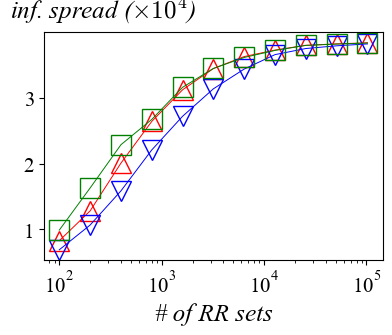

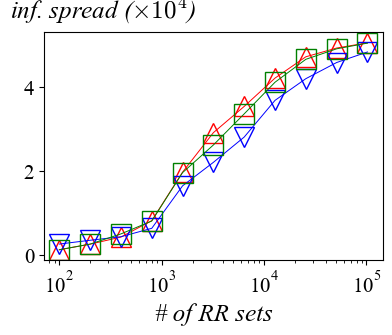

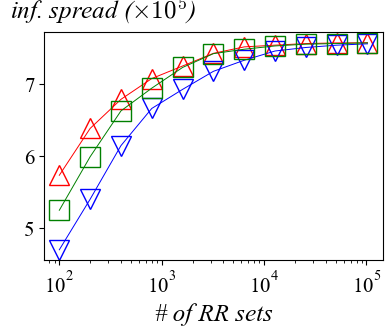

In [65]:
MARKER_SIZE=15
LABEL_SIZE=18
TICK_SIZE=15
FIG_SIZE=[4, 3.5]
plot_lines(inf_RRsets_epin_list,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label="inf. spread",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_RAND_epin.pdf"
           )
plot_lines(inf_RRsets_DBLP_list / 10000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_RAND_dblp.pdf"
           )
plot_lines(inf_RRsets_LJ_list / 10000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label=r"inf. spread ($\times 10^4$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_RAND_LJ.pdf"
           )

plot_lines(np.array(inf_RRsets_orkut_list) / 100000,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label=r"inf. spread ($\times 10^5$)",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_RAND_orkut.pdf"
           )

In [68]:
inf_RRsets_epin_dict = get_inf_numRRsets_of_one_dataset("Epinions", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"], seed_mode="OUTDEG")
inf_RRsets_epin_list = np.array(list(inf_RRsets_epin_dict.values()))

# inf_RRsets_DBLP_dict = get_inf_numRRsets_of_one_dataset("DBLP", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"], seed_mode="OUTDEG")
# inf_RRsets_DBLP_list = np.array(list(inf_RRsets_DBLP_dict.values()))

# inf_RRsets_LJ_dict = get_inf_numRRsets_of_one_dataset("LJ", list(range(2021, 2032)), ["AISPAC", "AugIM", "AIS"], seed_mode="OUTDEG")
# inf_RRsets_LJ_list = np.array(list(inf_RRsets_LJ_dict.values()))

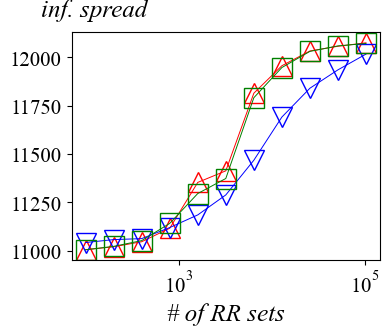

In [69]:
plot_lines(inf_RRsets_epin_list,
           line_labels=["AISPAC", "AugIM", "AIS"],
           x_axis=NUM_RR,
           ms=MARKER_SIZE,
           x_label="# of RR sets",
           y_label="inf. spread",
           tick_size=TICK_SIZE,
           label_size=LABEL_SIZE,
           fig_size=FIG_SIZE,
           y_label_pos=[-0.1, 1.1],
           x_logscale=True,
           save_path="./figs/inf_numRR_RAND_epin.pdf"
           )

## Small Datasets with 10000 candidate edges
### Baseline Methods

In [3]:
# runtime_grqc = get_runtime_of_one_dataset("GRQC", RAND_SEEDS, baseline_names=["IMA"], seed_mode="RAND", num_cand_edges=10000)
# runtime_nethept = get_runtime_of_one_dataset("nethept", rand_seeds_nethept, baseline_names=["IMA"], seed_mode="RAND", num_cand_edges=10000)
runtime_grqc = get_runtime_of_one_dataset("GRQC", RAND_SEEDS, baseline_names=["IMA"], seed_mode="IM", num_cand_edges=10000)
runtime_nethept = get_runtime_of_one_dataset("nethept", rand_seeds_nethept, baseline_names=["IMA"], seed_mode="IM", num_cand_edges=10000)


### MCGreedy data

In [27]:
MCG_time_k_grqc = get_runtime_k_mcg("GRQC", RAND_SEEDS)
MCG_time_k_nethept = get_runtime_k_mcg("nethept", RAND_SEEDS)
runtime_r_GRQC_step2k = get_runtime_r_mcg("GRQC", RAND_SEEDS)
runtime_r_nethept_step2k = get_runtime_r_mcg("nethept", RAND_SEEDS)
runtime_r_GRQC = get_runtime_r_mcg("GRQC", RAND_SEEDS, [i*1000 for i in range(1, 6)])
runtime_r_nethept = get_runtime_r_mcg("nethept", RAND_SEEDS, [i*1000 for i in range(1, 6)])
runtime_r_GRQC_IM = get_runtime_r_mcg("GRQC", RAND_SEEDS, [1000, 2000, 3000, 4000, 5000], "IM")
runtime_r_nethept_IM = get_runtime_r_mcg("nethept", RAND_SEEDS, [1000, 2000, 3000, 4000, 5000], "IM")

In [28]:
display_for_tex(runtime_r_nethept, "MCGreedy", [i for i in range(1, 6)])

(1,304.4098)
(2,326.0024)
(3,404.653)
(4,434.4754)
(5,640.8142)


In [11]:
display_for_tex(runtime_r_nethept_IM, "MCGreedy", [i*1000 for i in range(1,6)])

(1000,1510.126)
(2000,3024.026)
(3000,4641.218)
(4000,6418.404)
(5000,7780.71)


In [27]:
display_for_tex(runtime_nethept, "IMA", K_LIST)

(5,0.0957)
(10,0.3037)
(20,1.0251)
(30,2.2648)
(40,4.0737)
(50,6.259)


In [3]:
inf_beta_nethept = get_inf_beta_of_one_dataset("nethept", rand_seeds_nethept)
inf_beta_epinion = get_inf_beta_of_one_dataset("Epinions", RAND_SEEDS)
inf_beta_dblp = get_inf_beta_of_one_dataset("DBLP", RAND_SEEDS)
inf_beta_orkut = get_inf_beta_of_one_dataset("orkut", RAND_SEEDS)
inf_beta_twitter = get_inf_beta_of_one_dataset("twitter", RAND_SEEDS)

In [4]:
display_for_tex_all(inf_beta_twitter, [i for i in range(len(BETA_LIST))])

IMA:
(0,0.9984)
(1,0.9984)
(2,0.9984)
(3,0.9982)
(4,0.9999)
(5,0.9993)
(6,1.0)


In [5]:
time_beta_nethept = get_time_beta_of_one_dataset("nethept", rand_seeds_nethept)
time_beta_epinion = get_time_beta_of_one_dataset("Epinions", RAND_SEEDS)
time_beta_dblp = get_time_beta_of_one_dataset("DBLP", RAND_SEEDS)
time_beta_orkut = get_time_beta_of_one_dataset("orkut", RAND_SEEDS)
time_beta_twitter = get_time_beta_of_one_dataset("twitter", RAND_SEEDS)

In [6]:
display_for_tex_all(time_beta_twitter, [i for i in range(len(BETA_LIST))])

IMA:
(0,699.4426)
(1,459.037)
(2,339.8896)
(3,284.2249)
(4,243.919)
(5,224.9127)
(6,222.3034)


## EPSILON

In [4]:
eps_inf_nethept = get_eps_inf_of_one_dataset("nethept", rand_seeds_nethept)
eps_inf_epin = get_eps_inf_of_one_dataset("Epinions", RAND_SEEDS)
eps_inf_dblp = get_eps_inf_of_one_dataset("DBLP", RAND_SEEDS)
eps_inf_orkut = get_eps_inf_of_one_dataset("orkut", RAND_SEEDS)
eps_inf_twitter = get_eps_inf_of_one_dataset("twitter", RAND_SEEDS[:4])

In [5]:
display_for_tex_all(eps_inf_twitter, EPS_LIST)

IMA:
(0.1,1.0)
(0.2,1.0)
(0.3,0.9999)
(0.4,0.9999)
(0.5,0.9998)


In [8]:
eps_time_nethept = get_eps_time_of_one_dataset("nethept", rand_seeds_nethept)
eps_time_epin = get_eps_time_of_one_dataset("Epinions", RAND_SEEDS)
eps_time_dblp = get_eps_time_of_one_dataset("DBLP", RAND_SEEDS)
eps_time_orkut = get_eps_time_of_one_dataset("orkut", RAND_SEEDS)
eps_time_twitter = get_eps_time_of_one_dataset("twitter", RAND_SEEDS)

In [9]:
display_for_tex_all(eps_time_twitter, [0.1, 0.2, 0.3, 0.4, 0.5])

IMA:
(0.1,12171.155)
(0.2,3112.0224)
(0.3,1507.3786)
(0.4,941.1138)
(0.5,699.4426)


In [10]:
display_for_tex_all(eps_inf_nethept, [0.1, 0.2, 0.3, 0.4, 0.5])
display_for_tex_all(eps_inf_epin, [0.1, 0.2, 0.3, 0.4, 0.5])
display_for_tex_all(eps_inf_dblp, [0.1, 0.2, 0.3, 0.4, 0.5])
display_for_tex_all(eps_inf_orkut, [0.1, 0.2, 0.3, 0.4, 0.5])

IMA:
(0.1,0.9997)
(0.2,0.9998)
(0.3,1.0)
(0.4,0.9999)
(0.5,0.9992)
IMA:
(0.1,1.0)
(0.2,0.9999)
(0.3,0.9998)
(0.4,0.9998)
(0.5,1.0)
IMA:
(0.1,0.9999)
(0.2,1.0)
(0.3,0.9999)
(0.4,1.0)
(0.5,0.9997)
IMA:
(0.1,0.9999)
(0.2,0.9999)
(0.3,0.9999)
(0.4,1.0)
(0.5,0.9999)


In [14]:
runtime_nethept = get_runtime_of_one_dataset("nethept", rand_seeds_nethept, baseline_names=BASELINE_NAMES)
runtime_epin = get_runtime_of_one_dataset("Epinions", RAND_SEEDS, baseline_names=BASELINE_NAMES)
runtime_dblp = get_runtime_of_one_dataset("DBLP", RAND_SEEDS, baseline_names=BASELINE_NAMES)
runtime_orkut = get_runtime_of_one_dataset("orkut", RAND_SEEDS, baseline_names=BASELINE_NAMES)
runtime_twitter = get_runtime_of_one_dataset("twitter", RAND_SEEDS, baseline_names=BASELINE_NAMES)

In [15]:
display_for_tex_all(runtime_twitter, [5, 10, 20, 30, 40, 50])

RAND:
(5,9.9884)
(10,11.7806)
(20,16.2521)
(30,19.319)
(40,21.4907)
(50,26.7651)
OUTDEG:
(5,29.7318)
(10,29.9397)
(20,31.1671)
(30,29.7717)
(40,30.6306)
(50,32.1122)
PROB:
(5,52.178)
(10,52.243)
(20,53.6903)
(30,52.2959)
(40,53.2776)
(50,52.6929)
SINF:
(5,22.5067)
(10,52.9484)
(20,146.2096)
(30,271.7037)
(40,447.0782)
(50,641.6552)
UINF:
(5,24.3755)
(10,57.2389)
(20,153.8611)
(30,285.171)
(40,460.8796)
(50,663.262)
AIS-U:
(5,29.7778)
(10,68.4991)
(20,177.9643)
(30,318.9664)
(40,504.696)
(50,734.8698)
IMA:
(5,28.0647)
(10,64.1785)
(20,164.5828)
(30,302.3398)
(40,490.6986)
(50,699.4426)


In [18]:
display_for_tex(runtime_nethept, "IMA", K_LIST)

(5,0.5917)
(10,2.303)
(20,9.3477)
(30,21.0046)
(40,38.5388)
(50,58.8318)


In [12]:
get_runtime_of_one_dataset("DBLP", RAND_SEEDS)

{'SINF': array([ 0.7288724,  1.898564 ,  5.600618 , 11.020008 , 18.549964 ,
        28.136332 ]),
 'UINF': array([ 1.600365 ,  3.6491004,  9.106902 , 16.295694 , 25.62202  ,
        36.99108  ]),
 'AIS-U': array([ 1.801865 ,  4.0509464,  9.903734 , 17.479322 , 27.1619   ,
        38.86684  ]),
 'IMA': array([ 1.818009 ,  4.0850864,  9.97756  , 17.612822 , 27.38072  ,
        39.31004  ])}

In [10]:
res_nethept = get_inf_spread_of_one_dataset("nethept", rand_seeds_nethept)
res_epinions = get_inf_spread_of_one_dataset("Epinions", RAND_SEEDS)
res_dblp = get_inf_spread_of_one_dataset("DBLP", RAND_SEEDS)
# res_orkut = get_inf_spread_of_one_dataset("orkut", RAND_SEEDS)
# res_twitter = get_inf_spread_of_one_dataset("twitter", RAND_SEEDS)

In [11]:
display_for_tex_all(res_epinions)

RAND:
(0,12050.22)
(5,12053.06)
(10,12061.2)
(20,12082.0)
(30,12081.26)
(40,12081.02)
(50,12086.58)
OUTDEG:
(0,12050.22)
(5,12072.62)
(10,12089.4)
(20,12108.36)
(30,12105.86)
(40,12118.3)
(50,12141.26)
PROB:
(0,12050.22)
(5,12059.14)
(10,12068.92)
(20,12096.46)
(30,12102.1)
(40,12105.6)
(50,12110.98)
SINF:
(0,12050.22)
(5,12122.44)
(10,12207.0)
(20,12346.58)
(30,12461.46)
(40,12562.64)
(50,12655.48)
UINF:
(0,12050.22)
(5,12121.82)
(10,12197.16)
(20,12340.28)
(30,12434.8)
(40,12529.92)
(50,12621.9)
AIS-U:
(0,12050.22)
(5,12211.14)
(10,12361.68)
(20,12616.5)
(30,12846.62)
(40,13068.54)
(50,13262.12)
IMA:
(0,12050.22)
(5,12227.24)
(10,12381.96)
(20,12659.82)
(30,12893.82)
(40,13114.1)
(50,13316.74)


# AISPAC prelim results

In [10]:
runtime_epin = get_runtime_of_one_dataset("Epinions", RAND_SEEDS, baseline_names=["IMA", "AISPAC"])
runtime_dblp = get_runtime_of_one_dataset("DBLP", RAND_SEEDS, baseline_names=["IMA", "AISPAC"])

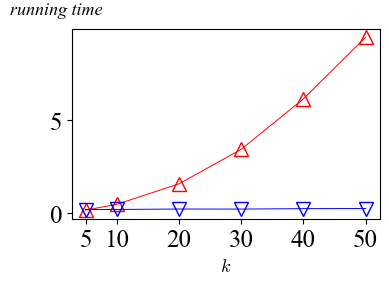

In [19]:
plot_lines([runtime_epin["IMA"], runtime_epin["AISPAC"]],
           line_labels=["IMA", "AISPAC"],
           x_axis=K_LIST,
           x_label=r"$k$",
           y_label="running time",
           save_path="./figs/time_k_epin.pdf",
           tick_size=18,
           ms=10)

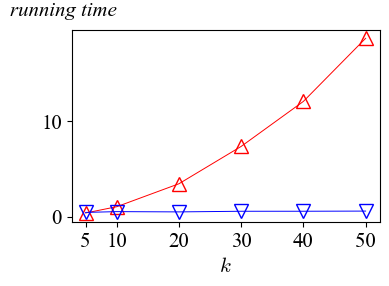

In [22]:
plot_lines([runtime_dblp["IMA"], runtime_dblp["AISPAC"]],
           line_labels=["IMA", "AISPAC"],
           x_axis=K_LIST,
           x_label=r"$k$",
           y_label="running time",
           save_path="./figs/time_k_dblp.pdf",
           tick_size=15,
           label_size=15,
           ms=10)

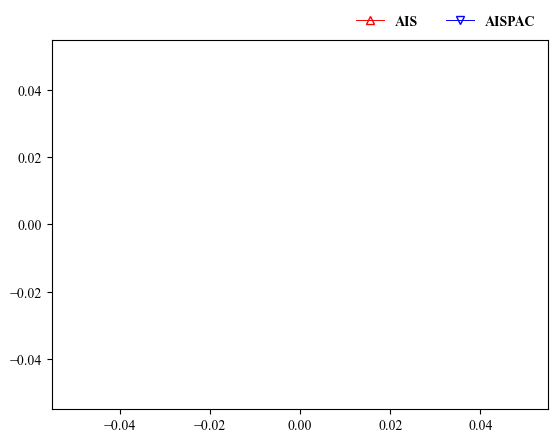

In [13]:
export_legend_for_labels(MARKERS_LIST, COLOR_LIST, ["AIS", "AISPAC", ], output_file="./figs/legend.pdf")

In [14]:
def plot_lines(arr_2d, line_labels, x_axis,
               save_path=None,
               marker_list=MARKERS_LIST,
               color_list=COLOR_LIST,
               ms=5,
               x_logscale=False,
               y_logscale=False,
               **kwargs):
    assert len(line_labels) >= len(arr_2d)
    if "fig_size" in kwargs.keys():
        plt.figure(figsize=kwargs["fig_size"])    
    else:
        plt.figure(figsize=(4, 3))
    axes = plt.gca()
    for i in range(len(arr_2d)):
        plt.plot(
            x_axis[:len(arr_2d[i])],
            arr_2d[i],
            marker=marker_list[i],
            color=color_list[i],
            fillstyle="none",
            linewidth=LINE_WIDTH,
            label=line_labels[i],
            markersize=ms
        )
    plt.xticks(x_axis)
    if "tick_size" in kwargs.keys():
        # axes.set_xticks(x_axis, fontsize=kwargs["tick_size"])
        # axes.set_yticks(fontsize=kwargs["tick_size"])
        axes.tick_params(labelsize=kwargs["tick_size"])
    if "x_ticks" in kwargs.keys():
        axes.set_xticklabels(kwargs["x_ticks"])
    if "y_ticks" in kwargs.keys():
        axes.set_yticklabels(kwargs["y_ticks"])
    if "x_label" in kwargs.keys():
        plt.xlabel(kwargs["x_label"],
                   fontstyle="italic",
                   fontsize=13)
    if "y_label" in kwargs.keys():
        plt.ylabel(kwargs["y_label"],
                   fontsize=13,
                   fontstyle="italic",
                   labelpad=20,
                   rotation=0,
                   ha='left', va='center'
                   )
        axes.yaxis.set_label_coords(-0.2, 1.1)
    
    if "y_label_pos" in kwargs.keys():
        axes.yaxis.set_label_coords(kwargs["y_label_pos"][0], kwargs["y_label_pos"][1])
    
    if "label_size" in kwargs.keys():
        axes.yaxis.label.set_size(kwargs["label_size"])
        axes.xaxis.label.set_size(kwargs["label_size"])
        
    if x_logscale:
        axes.set_xscale("log")
    if y_logscale:
        axes.set_yscale("log")
    if "title" in kwargs.keys():
        plt.title(kwargs["title"])
    
    if "display_legend" in kwargs.keys() and kwargs["display_legend"]:
        plt.legend()
    plt.tight_layout()
    if save_path != None:
        dir = os.path.split(save_path)[0]
        os.makedirs(dir, exist_ok=True)
        plt.savefig(save_path)
    plt.show()
    return

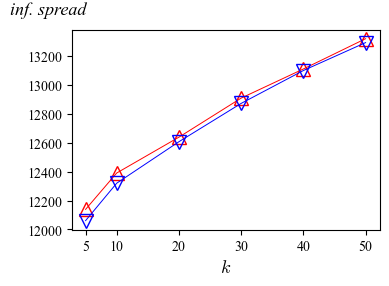

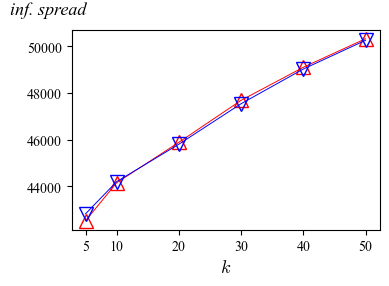

In [15]:
plot_lines([get_inf_from_csv_one_method("Epinions", "IMA"), get_inf_from_csv_one_method("Epinions", "AISPAC")],
           line_labels=["AIS", "AISPAC"],
           x_axis=[5, 10, 20, 30, 40, 50],
           ms=10,
           x_label=r"$k$",
           y_label="inf. spread",
           fig_size=[4, 3],
           save_path="./figs/inf_k_epin.pdf")
plot_lines([get_inf_from_csv_one_method("DBLP", "IMA"), get_inf_from_csv_one_method("DBLP", "AISPAC")],
           line_labels=["AIS", "AISPAC"],
           x_axis=[5, 10, 20, 30, 40, 50],
           ms=10,
           x_label=r"$k$",
           y_label="inf. spread",
           fig_size=[4, 3],
           save_path="./figs/inf_k_dblp.pdf")

In [35]:
def export_legend_for_labels(marker_list,
                             color_list,
                             label_list,
                             output_file="legend.pdf"):
    f = lambda m,c: plt.plot([],[],marker=m, color=c, fillstyle="none", linewidth=LINE_WIDTH)[0]
    handles = [f(marker_list[i], color_list[i]) for i in range(8)]
    legend_font = {"family" : "monospace",
                # "weight": "bold"
                }
    legend = plt.legend(handles,
                        label_list,
                        bbox_to_anchor=(1, 1.1),
                        # loc='best',
                        ncol=9,
                        framealpha=1,
                        frameon=False, 
                        prop=legend_font
                        )

    export_legend(legend, output_file)
    # plt.legend().remove()
    plt.show()
    return

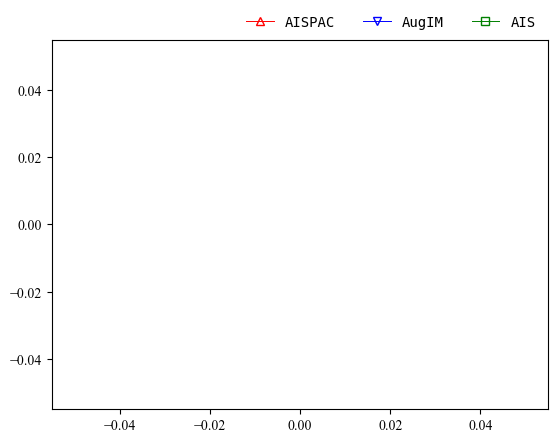

In [36]:
export_legend_for_labels(MARKERS_LIST, COLOR_LIST, ["AISPAC", "AugIM", "AIS"], "./figs/legend.pdf")